In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [59]:
# Importar os dados
url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
df = pd.read_csv(url)
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [60]:
print(f"Base de dados com {len(df)} linhas")

Base de dados com 150 linhas


In [61]:
# Alterando dados categóricos para numéricos
df['variety'] = df['variety'].replace('Setosa', 0)
df['variety'] = df['variety'].replace('Versicolor', 1)
df['variety'] = df['variety'].replace('Virginica', 2)
df['variety']

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: variety, Length: 150, dtype: int64

In [62]:
# Principio do Aprendizado de Maquina Supervisionado
data = df.drop('variety', axis=1) # Dados
labels = df['variety'] # Labels

In [63]:
# csv -> dados
data = data.values
labels = labels.values

In [64]:
# Dividindo dados para o processo de treino, teste e validação
from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(data, labels,
                                                                    test_size=0.2, random_state=41)
data_train, data_validation, labels_train, labels_validation = train_test_split(data_train, labels_train,
                                                                                test_size=0.1,
                                                                                random_state=1)
#https://justpaste.it/cf7rw
print(f'Quantidade de Dados para Treinamento : {len(data_train)}')
print(f'Quantidade de Dados para Validação : {len(data_test)}')
print(f'Quantidade de Dados para Teste : {len(data_validation)}')

Quantidade de Dados para Treinamento : 108
Quantidade de Dados para Validação : 30
Quantidade de Dados para Teste : 12


In [65]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        return self.data[idx], self.labels[idx]

In [66]:
dataset = DataSet(data_train,labels_train)
data_train = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

dataset = DataSet(data_validation,labels_validation)
data_validation = DataLoader(dataset, batch_size=len(data_validation), shuffle=True, num_workers=0)

dataset = DataSet(data_test,labels_test)
data_test = DataLoader(dataset, batch_size=len(data_test), shuffle=True, num_workers=0)

In [67]:
# Importação das Bibliotecas
import torch.nn as nn

# Criação do Modelo de Rede
    # 4 Entradas (4 Caracteristicas da Flor)
    # 2 Camadas de Neuronio
    # 3 Saidas (3 Rotulos de Flor)
class IrisClassifier(nn.Module) :
    def __init__(self, input_size = 4, hidden_size1=20, hidden_size2 = 10, output_size = 3) :
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, data) :
        data = self.relu(self.fc1(data))
        data = self.relu(self.fc2(data))
        data = self.output(data)
        return data

In [68]:
net = IrisClassifier()
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [69]:
def train_one_epoch(model,loss_function,optimizer,data_train):
    model.train()
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_train):
        x,y = data
        x = x.to(torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output,y)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [70]:
def validation_one_epoch(model,loss_function, data_validation):
    model.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0
    for i,data in enumerate(data_validation):
        x,y = data
        x = x.to(torch.float)
        output = model(x)
        loss = loss_function(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)
    return current_loss/(i+1), current_accuracy/total_samples

In [71]:
epochs = 1000
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
best_val_loss = 1e9

for epoch in range(epochs):

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(net,criterion,optimizer,data_train)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(net,criterion, data_validation)

    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < best_val_loss:
        best_val_loss = val_loss_per_epoch
        model_path = 'test_model'
        torch.save(net.state_dict(),model_path)

    if(epoch % 1 == 0) :
      print(f'Epóca [: {epoch}]')
      print(f'Erro de Treinamento: {train_loss_per_epoch}')
      print(f'Erro de Validação: {val_loss_per_epoch}')
      print(f'Acurácia de Treinamento: {train_accuracy_per_epoch}')
      print(f'Acurácia de Validação: {val_accuracy_per_epoch}')
      print()

A saída de streaming foi truncada nas últimas 5000 linhas.
Acurácia de Validação: 1.0

Epóca [: 167]
Erro de Treinamento: 0.02938514156267047
Erro de Validação: 0.002005618065595627
Acurácia de Treinamento: 0.9907407164573669
Acurácia de Validação: 1.0

Epóca [: 168]
Erro de Treinamento: 0.022220480313990265
Erro de Validação: 0.0007154099293984473
Acurácia de Treinamento: 1.0
Acurácia de Validação: 1.0

Epóca [: 169]
Erro de Treinamento: 0.027420575264841318
Erro de Validação: 0.0007103104144334793
Acurácia de Treinamento: 0.9814814925193787
Acurácia de Validação: 1.0

Epóca [: 170]
Erro de Treinamento: 0.02971867343876511
Erro de Validação: 0.0010433195857331157
Acurácia de Treinamento: 0.9814814925193787
Acurácia de Validação: 1.0

Epóca [: 171]
Erro de Treinamento: 0.038466860773041844
Erro de Validação: 0.0010374461999163032
Acurácia de Treinamento: 0.9907407164573669
Acurácia de Validação: 1.0

Epóca [: 172]
Erro de Treinamento: 0.06925232522189617
Erro de Validação: 0.0006435794

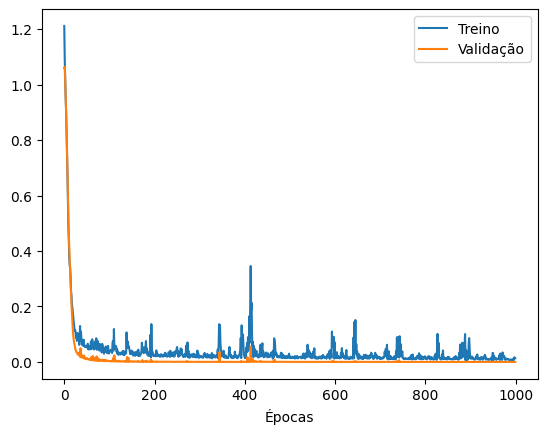

In [72]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

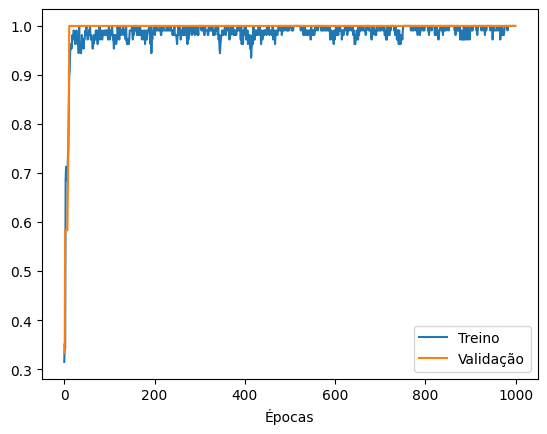

In [73]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

net.train(False)
for data in data_test:
    x_test, y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    c_matrix = confusion_matrix(y_test, y_pred, labels=range(3))

c_matrix

array([[ 9,  0,  0],
       [ 0, 10,  1],
       [ 0,  1,  9]])

In [75]:
from sklearn.metrics import classification_report

net.train(False)

for data in data_test:
    x_test,y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)

    print(classification_report(y_test,y_pred,zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.91      0.91      0.91        11
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.94        30
weighted avg       0.93      0.93      0.93        30



In [76]:

for data in data_test:
    x_test,y_test = data
    x_test = x_test.to(torch.float32)
    y_pred = net(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)

    print(y_test)
    print(y_pred)

tensor([2, 2, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0,
        2, 1, 2, 2, 2, 1])
tensor([2, 2, 1, 1, 2, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        2, 1, 2, 2, 2, 1])
